**In this notebook we are going to cover all types of recommender systems(Except For Hybrid Which I Will Update Soon) in python using the IMDB Movie Dataset**

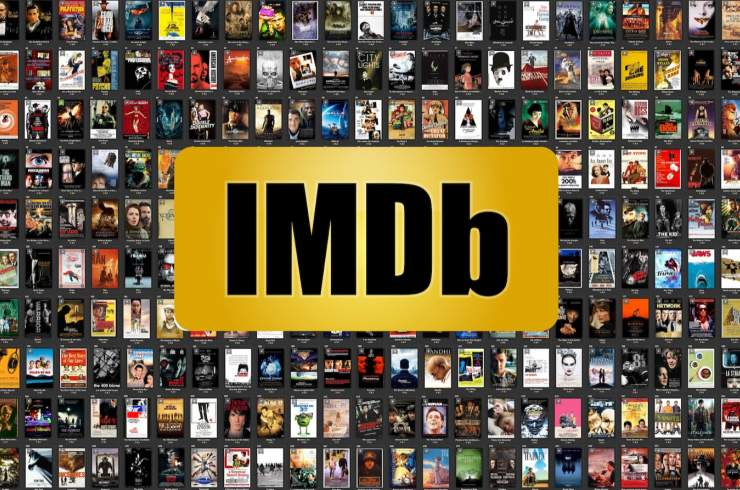

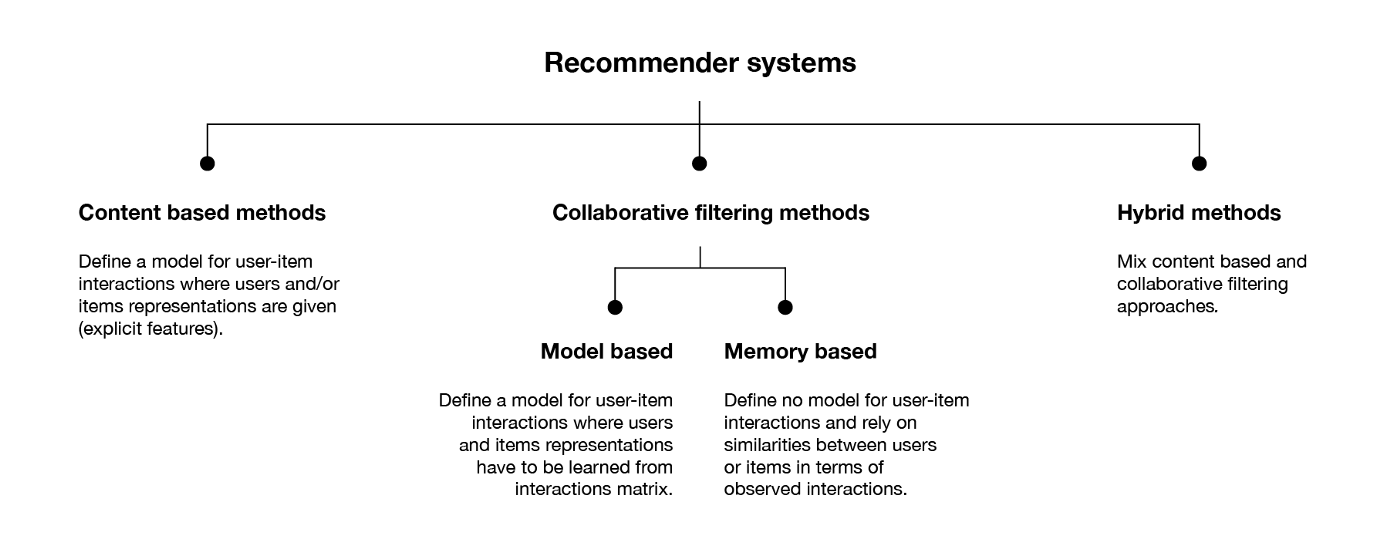

In [1]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#6166B3', '#e8eff6', '#0b2553']

prompt = color_map[-1]
main_color = color_map[0]

css_file = '''

    div #notebook {
    background-color: white;
    line-height: 20px;
    }

    #notebook-container {
    %s
    margin-top: 2em;
    padding-top: 2em;
    border-top: 4px solid %s; /* light orange */
    -webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    }

    div .input {
    margin-bottom: 1em;
    }

    .rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
    color: %s; /* light orange */
    font-weight: 600;
    }

    div.input_area {
    border: none;
        background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
        border-top: 2px solid %s; /* light orange */
    }

    div.input_prompt {
    color: %s; /* light blue */
    }

    div.output_prompt {
    color: %s; /* strong orange */
    }

    div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
    background: %s; /* light orange */
    }

    div.cell.selected, div.cell.selected.jupyter-soft-selected {
        border-color: %s; /* light orange */
    }

    .edit_mode div.cell.selected:before {
    background: %s; /* light orange */
    }

    .edit_mode div.cell.selected {
    border-color: %s; /* light orange */

    }
    '''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

#### **Import Libraries**

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

#### **Read the data**

In [3]:
# Read the movies meta-data(we will be using the feature genre, overview & title from this)
movie_md = pd.read_csv("../input/the-movies-dataset/movies_metadata.csv")

# Read the keywords
movie_keywords = pd.read_csv("../input/the-movies-dataset/keywords.csv")

# Read the credits
movie_credits = pd.read_csv("../input/the-movies-dataset/credits.csv")

#### **Check the first 5 rows**

In [4]:
movie_md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


**We are gonna select movies which have more than 55 vote count**

In [5]:
movie_md = movie_md[movie_md['vote_count']>=55]

In [6]:
movie_md = movie_md[['id','original_title','overview','genres']]

In [7]:
# Creating a duplicate column for title so that once can be used to search later and one for creating features
movie_md['title'] = movie_md['original_title'].copy()

In [8]:
movie_md.reset_index(inplace=True, drop=True)
movie_md.head()

,id,original_title,overview,genres,title
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat


In [9]:
movie_keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [10]:
movie_credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [11]:
movie_credits = movie_credits[['id','cast']]

### **Data Cleaning & Preprocessing**

In [12]:
# Removing the records for which the id is not available
movie_md = movie_md[movie_md['id'].str.isnumeric()]

#### Merge dataframes into one single entity

In [13]:
# Merge all dataframe as a single entity
# To merge the ids must be of same datatype
movie_md['id'] = movie_md['id'].astype(int)

# Merge
df = pd.merge(movie_md, movie_keywords, on='id', how='left')

# Reset the index
df.reset_index(inplace=True, drop=True)

In [14]:
# Merge with movie credits
df = pd.merge(df, movie_credits, on='id', how='left')

# Reset the index
df.reset_index(inplace=True, drop=True)

In [15]:
df.head()

,id,original_title,overview,genres,title,keywords,cast
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '..."
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '..."
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'cast_id': 25, 'character': 'Lt. Vincent Han..."


### Let's fetch the genres, keywords, cast to vectorize them later

In [16]:
# Lets first start with cleaning the movies metadata
# Fetchin the genre list from the column
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in eval(x)])

# Replaces spaces in between genre(ex - sci fi to scifi) and make it a string
df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))

In [17]:
# Filling the numm values as []
df['keywords'].fillna('[]', inplace=True)

In [18]:
# Let's clean the keywords dataframe to extract the keywords
# Fetchin the keyword list from the column     
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the keyword wwwith spaces
df['keywords'] = df['keywords'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [19]:
# Filling the numm values as []
df['cast'].fillna('[]', inplace=True)

In [20]:
# Let's clean the cast dataframe to extract the name of aactors from cast column
# Fetchin the cast list from the column
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the cast with spaces
df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [21]:
df.head()

,id,original_title,overview,genres,title,keywords,cast
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation Comedy Family,Toy Story,jealousy toy boy friendship friends rivalry bo...,TomHanks TimAllen DonRickles JimVarney Wallace...
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,Adventure Fantasy Family,Jumanji,boardgame disappearance basedonchildren'sbook ...,RobinWilliams JonathanHyde KirstenDunst Bradle...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance Comedy,Grumpier Old Men,fishing bestfriend duringcreditsstinger oldmen,WalterMatthau JackLemmon Ann-Margret SophiaLor...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,Father of the Bride Part II,baby midlifecrisis confidence aging daughter m...,SteveMartin DianeKeaton MartinShort KimberlyWi...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...",Action Crime Drama Thriller,Heat,robbery detective bank obsession chase shootin...,AlPacino RobertDeNiro ValKilmer JonVoight TomS...


### **Let's merge all content/description of movies as a single feature**

In [22]:
df['tags'] = df['overview'] + ' ' + df['genres'] +  ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']

In [23]:
# Delete useless columns
df.drop(columns=['genres','overview','original_title','keywords','cast'], inplace=True)

In [24]:
df.head()

,id,title,tags
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ..."


In [25]:
df.isnull().sum()

id        0
title     0
tags     35
dtype: int64

* **These null values are the values for which the data was not available, hence, we would have to remove these records inorder to proceed further**

In [26]:
df.drop(df[df['tags'].isnull()].index, inplace=True)

In [27]:
df.head()

,id,title,tags
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ..."


In [28]:
df.shape

(8735, 3)

In [29]:
df.drop_duplicates(inplace=True)

In [30]:
df.shape

(8595, 3)

## **Convert the contents to vectors**

As our model will not be able to understand text inputs we would have to vectorize them and make it in form of machine readable format

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
# Initialize a tfidf object
tfidf = TfidfVectorizer(max_features=5000)

# Transform the data
vectorized_data = tfidf.fit_transform(df['tags'].values)

In [33]:
vectorized_data

<8595x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 375635 stored elements in Compressed Sparse Row format>

In [34]:
vectorized_dataframe = pd.DataFrame(vectorized_data.toarray(), index=df['tags'].index.tolist())

## **Perform Dimension Reduction**

We are gonna perform dimensional reduction as computing similarities with such huge dimensions would be exremely computationally expensive

In [35]:
from sklearn.decomposition import TruncatedSVD

In [36]:
# Initialize a PCA object
svd = TruncatedSVD(n_components=3000)

# Fit transform the data
reduced_data = svd.fit_transform(vectorized_dataframe)

# Print the shape
reduced_data.shape

(8595, 3000)

In [37]:
svd.explained_variance_ratio_.cumsum()

array([0.00470896, 0.01167374, 0.01736822, ..., 0.9218902 , 0.92196289,
       0.92203565])

## **Compute a similarity metric on vectors for recommendation**
Now in order to make recommendations we would have to compute any similarity index ex- cosine similarity, eucledian distance, Jaccard distance, etc. here we are going to use cosine similarity

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
similarity = cosine_similarity(reduced_data)

## **Making recommendations for a given movie**

In [40]:
def recommendation(movie_title):
    id_of_movie = df[df['title']==movie_title].index[0]
    distances = similarity[id_of_movie]
    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:10]
    
    for i in movie_list:
        print(df.iloc[i[0]].title)

In [41]:
recommendation('The Matrix')

The Matrix Revisited

The Matrix Revolutions

The Matrix Reloaded

The Animatrix

Commando

Terminator 3: Rise of the Machines

GHOST IN THE SHELL

Hackers

Who Am I - Kein System ist sicher


In [42]:
recommendation('Jumanji')

Brainscan

Wreck-It Ralph

Geri's Game

Stay Alive

Alan Partridge: Alpha Papa

Dungeons & Dragons

Nirvana

Indie Game: The Movie

Jack the Giant Slayer


In [43]:
recommendation('Casino')

Lucky You

Last Vegas

Vegas Vacation

Fear and Loathing in Las Vegas

The Godfather: Part II

La mafia uccide solo d'estate

Mississippi Grind

The Cincinnati Kid

Wild Card


<a id='visualize'></a>
## **Let's try to visualize the vectors in 2-D space using T-SNE**

In [44]:
from sklearn.manifold import TSNE

In [45]:
# Initialize TSNE object
tsne = TSNE(n_components=2)

# Fir transform the data
tsne_data = tsne.fit_transform(vectorized_data)

# Convert to dataframe
tsne_data = pd.DataFrame(tsne_data, columns=['x','y'])

In [46]:
tsne_data['title'] = df['title'].copy()

In [47]:
data = go.Scatter(x=tsne_data['x'],y=tsne_data['y'],text=tsne_data['title'],mode='markers+text',)

fig = go.Figure(data=data)

fig.show()

<a id='model_based'></a>
## **Model Based Recommender Systems**

Model-based recommendation systems involve building a model based on the dataset of ratings. In other words, we extract some information from the dataset, and use that as a "model" to make recommendations without having to use the complete dataset every time.

For model based recommender systems we are going to use a library called Surprise and we are going to use SVD as a matrix factorization method.

#### **Import Libraries**

In [48]:
from surprise import Dataset, Reader

from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise import accuracy

#### **Read the data**

In [49]:
ratings = pd.read_csv("../input/the-movies-dataset/ratings_small.csv")

movie_md = pd.read_csv("../input/the-movies-dataset/movies_metadata.csv")

ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


* We will consider ratings for movies which have more than 55 counts

In [50]:
# movie dataframe with votes more than 55
movie_md = movie_md[movie_md['vote_count']>55][['id','title']]

# IDs of movies with count more than 55
movie_ids = [int(x) for x in movie_md['id'].values]

# Select ratings of movies with more than 55 counts
ratings = ratings[ratings['movieId'].isin(movie_ids)]

# Reset Index
ratings.reset_index(inplace=True, drop=True)

# Print first 5 rows
ratings.head()

,userId,movieId,rating,timestamp
0,1,1371,2.5,1260759135
1,1,2105,4.0,1260759139
2,1,2294,2.0,1260759108
3,2,17,5.0,835355681
4,2,62,3.0,835355749


In [51]:
ratings.shape

(29965, 4)

In [52]:
# Initialize a surprise reader object
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5), skip_lines=1)

# Load the data
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

# Build trainset object(perform this only when you are using whole dataset to train)
trainset = data.build_full_trainset()

In [53]:
# Initialize model
svd = SVD()

# cross-validate
svd.fit(trainset)

**We have fit the data successfully, now let's check some predictions**

In [54]:
svd.predict(uid=3,iid=2959,r_ui=5.0)

Prediction(uid=3, iid=2959, r_ui=5.0, est=4.299221068458871, details={'was_impossible': False})

In [55]:
svd.predict(uid=15,iid=2678,r_ui=1.0)

Prediction(uid=15, iid=2678, r_ui=1.0, est=2.8211836522598652, details={'was_impossible': False})

In [56]:
def get_recommendations(data, movie_md, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_movie_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those product ids which the user_id has not interacted yet
    non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        movie_name = movie_md[movie_md['id']==str(item_id)]['title'].values[0]
        recommendations.append((movie_name, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [57]:
get_recommendations(data=ratings,movie_md=movie_md, user_id=654, top_n=10, algo=svd)

[('Straw Dogs', 4.9843759342865095),
 ('Mission: Impossible', 4.960114517892553),
 ('Bonnie and Clyde', 4.953774031927298),
 ('Galaxy Quest', 4.945630445840485),
 ('Dead Man', 4.9283949106955545),
 ('While You Were Sleeping', 4.8909063743317525),
 ('Nell', 4.864623033405785),
 ('Scarface', 4.855403783513467),
 ('Flags of Our Fathers', 4.832664100116681),
 ('The Sixth Sense', 4.807656708304399)]

#### **Import Libraries**

In [58]:
from surprise.prediction_algorithms.knns import KNNBasic

In [59]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find similar items
sim_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user.fit(trainset)

In [60]:
#predicting rating for a sample user with an interacted product.
sim_user.predict(uid=2,iid=17,r_ui=5.0)

Prediction(uid=2, iid=17, r_ui=5.0, est=4.166335018545322, details={'actual_k': 40, 'was_impossible': False})

In [61]:
#predicting rating for a sample user with an interacted product.
sim_user.predict(uid=671,iid=4011,r_ui=4.0)

Prediction(uid=671, iid=4011, r_ui=4.0, est=4.262454431125302, details={'actual_k': 40, 'was_impossible': False})

In [62]:
get_recommendations(ratings, movie_md, 671,10,sim_user)

[('The Wizard', 5),
 ('Rio Bravo', 5),
 ('The Celebration', 5),
 ('Spider-Man 3', 5),
 ('A Streetcar Named Desire', 5),
 ('Gentlemen Prefer Blondes', 5),
 ('The Evil Dead', 5),
 ('JFK', 5),
 ('Strangers on a Train', 5),
 ("Singin' in the Rain", 5)]

In [63]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find similar items
sim_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item.fit(trainset)

In [64]:
#predicting rating for a sample user with an interacted product.
sim_item.predict(uid=2,iid=17,r_ui=5.0)

Prediction(uid=2, iid=17, r_ui=5.0, est=3.650476877827318, details={'actual_k': 40, 'was_impossible': False})

In [65]:
#predicting rating for a sample user with an interacted product.
sim_item.predict(uid=671,iid=4011,r_ui=4.0)

Prediction(uid=671, iid=4011, r_ui=4.0, est=4.164142698155605, details={'actual_k': 31, 'was_impossible': False})

In [66]:
get_recommendations(ratings, movie_md, 671,10,sim_item)

[('Hard Candy', 5),
 ('Visitor Q', 5),
 ('The Protector', 4.666666666666667),
 ('Shaun of the Dead', 4.571428571428571),
 ('The Silence of the Lambs', 4.503228000162119),
 ("Singin' in the Rain", 4.5),
 ("Hearts of Darkness: A Filmmaker's Apocalypse", 4.5),
 ('Sense and Sensibility', 4.5),
 ("The Hitchhiker's Guide to the Galaxy", 4.5),
 ('Fantasia', 4.428571428571429)]